In [7]:
! pip install mxnet

     |████████████████████████████████| 55.0MB 76kB/s 


In [8]:
from mxnet.gluon import nn

net = nn.Sequential()

net.add(nn.Dense(64,                    # Dense layer-1 with 64 units
                 in_units=3,            # Input size of 3 is expected
                 activation='tanh'),    # Tanh activation is applied
        nn.Dropout(.4),                 # Apply random 40% drop-out to layer_1
        
        nn.Dense(64,                   # Dense layer-2 with 64 units  
                 activation='tanh'),    # Tanh activation is applied
                
        nn.Dropout(.3),                 # Apply random 30% drop-out to layer_2
        
        nn.Dense(1))                    # Output layer with single unit

print(net)

Sequential(
  (0): Dense(3 -> 64, Activation(tanh))
  (1): Dropout(p = 0.4, axes=())
  (2): Dense(None -> 64, Activation(tanh))
  (3): Dropout(p = 0.3, axes=())
  (4): Dense(None -> 1, linear)
)


In [9]:
from mxnet import init

net.initialize(init=init.Xavier())

In [10]:
print(net[0])
print(net[1])
print(net[2])
print(net[3])
print(net[4])

Dense(3 -> 64, Activation(tanh))
Dropout(p = 0.4, axes=())
Dense(None -> 64, Activation(tanh))
Dropout(p = 0.3, axes=())
Dense(None -> 1, linear)


In [11]:
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss
loss = SigmoidBinaryCrossEntropyLoss()

In [12]:
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
loss = SoftmaxCrossEntropyLoss()

In [13]:
from mxnet.gluon.loss import L2Loss
loss = L2Loss()

In [14]:
from mxnet import gluon

trainer = gluon.Trainer(net.collect_params(),
                        'sgd', 
                        {'learning_rate': 0.001}
                       )

In [15]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=750, shuffle=True, random_state=42, noise=0.05, factor=0.3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


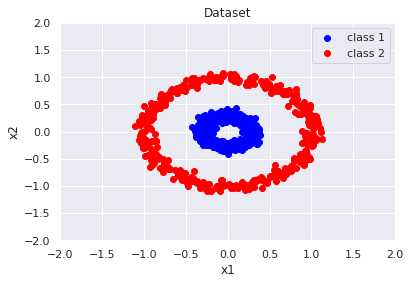

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset(X, y, title):
    
    # Activate Seaborn visualization
    sns.set()
    
    # Plot both classes: Class1->Blue, Class2->Red
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label="class 1")
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label="class 2")
    plt.legend(loc='upper right')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title(title)
    plt.show()
    
plot_dataset(X, y, title="Dataset")


In [17]:
import time
import mxnet as mx
from mxnet import gluon, autograd
import mxnet.ndarray as nd
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

In [18]:
from mxnet import init
from mxnet.gluon import nn

net = nn.Sequential()
net.add(nn.Dense(10, in_units=2, activation='relu'),
        nn.Dense(10, activation='relu'),
        nn.Dense(1, activation='sigmoid'))
net.initialize(init=init.Xavier())

In [19]:
# Split the dataset into two parts: 80%-20% split
X_train, X_val = X[0:int(len(X)*0.8), :], X[int(len(X)*0.8):, :]
y_train, y_val = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

# Convert to ND arrays for gluon
X_train = nd.array(X_train)
X_val = nd.array(X_val)
y_train = nd.array(y_train)
y_val = nd.array(y_val)

# Use Gluon Data loaders to load the data in batches
batch_size = 4           # How many samples to use for each weight update 
train_dataset = gluon.data.ArrayDataset(X_train, y_train)
train_loader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)

In [20]:
epochs = 50              # Total number of iterations
learning_rate = 0.01     # Learning rate
context = mx.cpu()       # Using CPU resource

# Define the loss. As we used sigmoid in the last layer, use from_sigmoid=True
binary_cross_loss = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)

# Define the trainer, SGD with learning rate
trainer = gluon.Trainer(net.collect_params(),
                        'sgd',
                        {'learning_rate': learning_rate}
                       )

In [21]:
import time

train_losses = []
val_losses = []
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Build a training loop, to train the network
    for idx, (data, target) in enumerate(train_loader):

        data = data.as_in_context(context)
        target = target.as_in_context(context)
        
        with autograd.record():
            output = net(data)
            L = binary_cross_loss(output, target)
            training_loss += nd.sum(L).asscalar()
            L.backward()
        trainer.step(data.shape[0])
    
    # Get validation predictions
    val_predictions = net(X_val.as_in_context(context))
    # Calculate the validation loss
    val_loss = nd.sum(binary_cross_loss(val_predictions, y_val)).asscalar()
    
    # Take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    
    end = time.time()
    # Print the losses every 10 epochs
    if (epoch == 0) or ((epoch+1)%10 == 0):
        print("Epoch %s. Train_loss %f Validation_loss %f Seconds %f" % \
              (epoch, training_loss, val_loss, end-start))


Epoch 0. Train_loss 0.717287 Validation_loss 0.707328 Seconds 0.637434
Epoch 9. Train_loss 0.536602 Validation_loss 0.528374 Seconds 0.591531
Epoch 19. Train_loss 0.183823 Validation_loss 0.171154 Seconds 0.611217
Epoch 29. Train_loss 0.030300 Validation_loss 0.029884 Seconds 0.594926
Epoch 39. Train_loss 0.012365 Validation_loss 0.013041 Seconds 0.588442
Epoch 49. Train_loss 0.007204 Validation_loss 0.007897 Seconds 0.583187


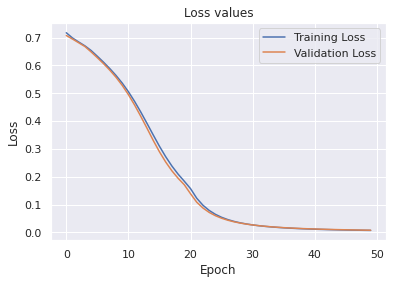

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()